# Exploratory Data Analysis of Pro-Level League of Legends Matches
***

The data being used was obtained from [Oracle's Elixer] (using upload from September 18th). A [codebook] for the variables is also included.

[Oracle's Elixer]: http://oracleselixir.com/match-data/
[codebook]: http://oracleselixir.com/match-data/match-data-dictionary/

## Getting the data and preparing the workspace

First I will import all neccessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

Then I will download a series of .xlsx links, read them into a pandas dataframe and concatenate them together. I will also save this initial dataset for reproducibility (and for consistency in the event the original .xlsx files are updated as I build out my analysis).

In [11]:
# List of excel file url's to read and join together
# root_url = "http://oracleselixir.com/gamedata/"
# urls = ["2016-spring/", "2017-spring/", "2017-summer/"]
# urls = [root_url + url for url in urls]

# partial_dfs = [pd.read_excel(url, 'Sheet1') for url in urls]
# df = pd.concat(partial_dfs, ignore_index = True)

# Save df as a csv for future work.
# df.to_csv(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\Raw-LoL-Data.csv')

# Read df from csv if the files have been updated.
df = pd.read_csv('C:/Users/glander/Documents/DataScience/Springboard/Capstone1/Raw-LoL-Data.csv', encoding = "ISO-8859-1", index_col = 0)

C:\Users\glander\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7,18,19,34,35,36,37,71,82) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Processing the data
***
I'll take a quick look at the dataset.

In [12]:
print(df.head(10))
print(df.info())

    gameid                                                url league   split  \
0  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
1  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
2  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
3  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
4  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
5  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
6  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
7  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
8  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   
9  1160150  http://matchhistory.na.leagueoflegends.com/en/...    LCK  2016-2   

           date  week game  patchno  playerid  side   ...         cspm  \
0  42578.113113  10.3    1     6.14         1

As there are 33 object type columns that correspond to either numeric or categorical variables, they need to be recast for analysis. There are also two numeric types (patchno and playerid) that need to be coerced to categorical variables.

In [13]:
#Filter object type columns that will be converted to numeric.
objCols = df.columns[df.dtypes == object][16:]

for col in objCols:
    try:
        df[col] = pd.to_numeric(df[col], errors = 'coerce')
    except:
        print('Column {} cannot be converted to numeric.'.format(col))
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64692 entries, 0 to 64691
Data columns (total 92 columns):
gameid                     64692 non-null object
url                        54108 non-null object
league                     64692 non-null object
split                      64692 non-null object
date                       57937 non-null float64
week                       64692 non-null object
game                       64692 non-null object
patchno                    64692 non-null float64
playerid                   64692 non-null int64
side                       64692 non-null object
position                   64692 non-null object
player                     64692 non-null object
team                       64692 non-null object
champion                   64692 non-null object
ban1                       64506 non-null object
ban2                       64626 non-null object
ban3                       64518 non-null object
ban4                       35874 non-null object
ban5    

In [14]:
#Filter object type columns that will be converted to categorical dtype.
objCols = list(df.columns[df.dtypes == object][2:16])
objCols += ['patchno', 'playerid']
print(objCols)

for col in objCols:
    try:
        df[col] = df[col].astype('category')
    except:
        print('Column {} cannot be converted to categorical.'.format(col))
print(df.info())

['league', 'split', 'week', 'game', 'side', 'position', 'player', 'team', 'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'patchno', 'playerid']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64692 entries, 0 to 64691
Data columns (total 92 columns):
gameid                     64692 non-null object
url                        54108 non-null object
league                     64692 non-null category
split                      64692 non-null category
date                       57937 non-null float64
week                       64692 non-null category
game                       64692 non-null category
patchno                    64692 non-null category
playerid                   64692 non-null category
side                       64692 non-null category
position                   64692 non-null category
player                     64692 non-null category
team                       64692 non-null category
champion                   64692 non-null category
ban1                       64506 

#### NOTE - 'date' column conversion error:

The 'date column was originally being read as a float. My guess was that this meant pandas was taking a date like 2017/04/23 and interpretting it as: $\frac{2017}{\frac{4}{23}} $

I attempted to read in the 'date' column as a string to see how it was formatted so that I would know the correct parsing syntax to read it as a datetime. However, the problem with the date showing up as a float still remained. I tried looking at the column in one of the smaller .xlsx files directly and the problem was present even there, leading my to suspect the entire column was miscast when the dataset was created.

In [15]:
dateTest = pd.ExcelFile("http://oracleselixir.com/gamedata/2016-spring/")
rows = dateTest.book.sheet_by_index(0).nrows
nrows = 10
dateTestDF = pd.read_excel(dateTest, 'Sheet1', skip_footer = (rows - nrows - 1), usecols = ['date'], dtype = {'date': str})

print(dateTestDF)
print(dateTestDF.info())
print(type(dateTestDF.iloc[0,0]))

                date
0  42578.11311342593
1  42578.11311342593
2  42578.11311342593
3  42578.11311342593
4  42578.11311342593
5  42578.11311342593
6  42578.11311342593
7  42578.11311342593
8  42578.11311342593
9  42578.11311342593
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
date    10 non-null object
dtypes: object(1)
memory usage: 160.0+ bytes
None
<class 'str'>


***
#### Segmenting the data:

Now that the column data types have been properly coerced, I will split the data into two separate data frames - one for team level data and the other for individual player data.

In [16]:
teamDF = df[df['player'] == 'Team']
playerDF = df[df['player'] != 'Team']

## Exploratory Data Analysis
***

I'll start by looking at a heatmap of the correlation matrix for `teamDF`. It appears there are a lot of strongly correlated variables, but it's difficult to see which they are due to the large number of variables.

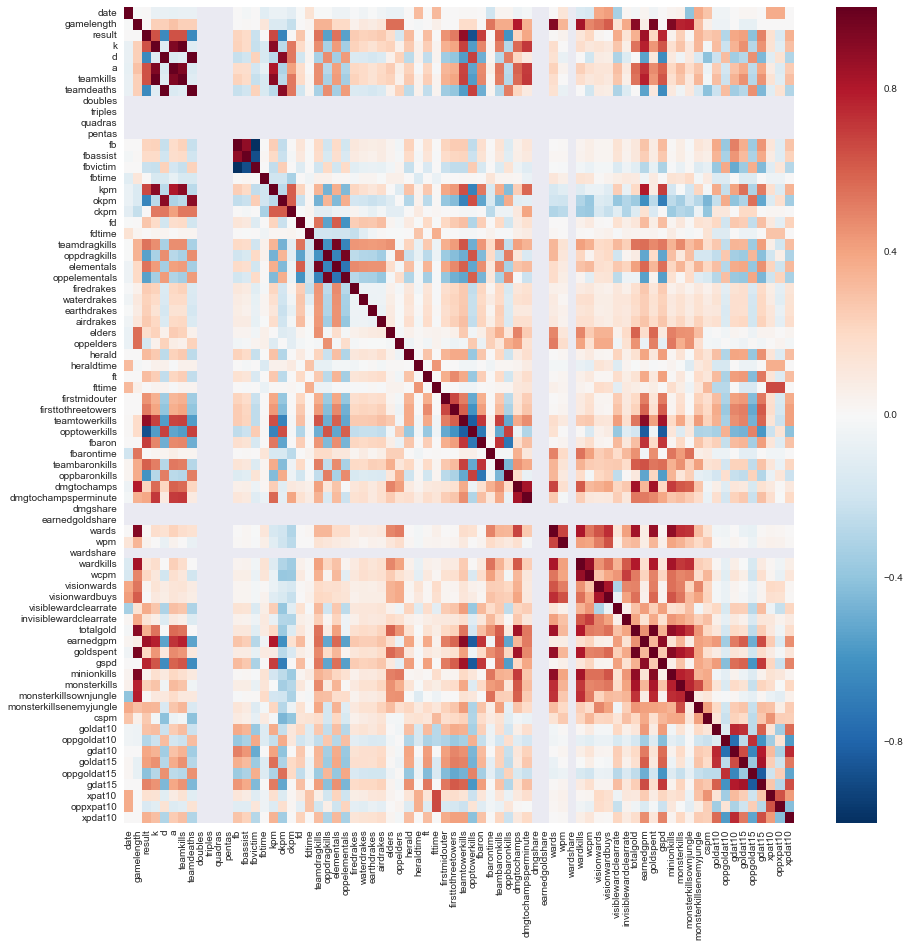

In [17]:
corr = teamDF.corr()
plt.figure(figsize = (15,15))
sb.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

I'd like to reduce the number of columns I'm using to get a clearer picture. Rather than looking at all of the individual correlations between columns, I'm mostly interested in how the columns correlate with the 'result' column.

First I'll explore this numerically, to see which columns are the most strongly correlated to the response.

In [18]:
print(teamDF.corrwith(teamDF[['result']]))

a                       NaN
airdrakes               NaN
ckpm                    NaN
cspm                    NaN
d                       NaN
date                    NaN
dmgshare                NaN
dmgtochamps             NaN
dmgtochampsperminute    NaN
doubles                 NaN
earnedgoldshare         NaN
earnedgpm               NaN
earthdrakes             NaN
elders                  NaN
elementals              NaN
fb                      NaN
fbaron                  NaN
fbarontime              NaN
fbassist                NaN
fbtime                  NaN
fbvictim                NaN
fd                      NaN
fdtime                  NaN
firedrakes              NaN
firstmidouter           NaN
firsttothreetowers      NaN
ft                      NaN
fttime                  NaN
gamelength              NaN
gdat10                  NaN
                       ... 
okpm                    NaN
oppbaronkills           NaN
oppdragkills            NaN
oppelders               NaN
oppelementals       

Unfortunately, (I think) because the 'result' column contains binary categorical data, the default pearson correlation method doesn't work here.

Instead, I'll try to look at correlation through Point-Biserial Correlation Coefficient.

In [19]:
# After lots of headbanging, I realized that Point-Biserial won't work for comparing
# dichotomous data with an array of object type. For now I've just dropped all columns
# of that type from the correlation analysis. But I'll revisit this later, as there are
# definitely important, potential predictors being dropped.

numCols = teamDF.columns[teamDF.dtypes == np.number]

corrResult = [stats.pointbiserialr(teamDF[['result']][pd.notnull(teamDF[col])], teamDF[[col]][pd.notnull(teamDF[col])])[0] for col in numCols]
corrResult = [n[0] for n in corrResult]
corrResult = pd.Series(corrResult, index = numCols)
corrResult = corrResult.dropna()
print(corrResult.sort_values())

C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3016: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
C:\Users\glander\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3017: RuntimeWarning: Mean of empty slice.
  my = y.mean()
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3021: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3025: RuntimeWarning: invalid value encountered in greater
  r = max(min(r, 1.0), -1.0)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:3025: RuntimeWarning: invalid value encountered in less
  r = max(min(r, 1.0), -1.0)
C:\Users\glander\Anaconda3\lib\site-packages\scipy\stats\stats.py:5277: RuntimeWarning: invalid value encountered in less
  x =

opptowerkills             -0.882038
okpm                      -0.658117
oppbaronkills             -0.600284
oppdragkills              -0.544083
oppelementals             -0.541514
oppgoldat15               -0.413154
oppgoldat10               -0.291724
fbvictim                  -0.223947
oppelders                 -0.174521
oppxpat10                 -0.150927
date                       0.000000
fttime                     0.000000
heraldtime                 0.000000
fbarontime                 0.000000
fdtime                     0.000000
ckpm                       0.000000
gamelength                 0.000000
fbtime                     0.000000
visionwardbuys             0.004010
wards                      0.010475
monsterkillsownjungle      0.014367
visionwards                0.025927
wpm                        0.039214
minionkills                0.045806
wardkills                  0.119385
invisiblewardclearrate     0.135190
xpat10                     0.150927
elders                     0

Finally, we can create a readable heatmap for the features most correlated (positively and negatively) with result.

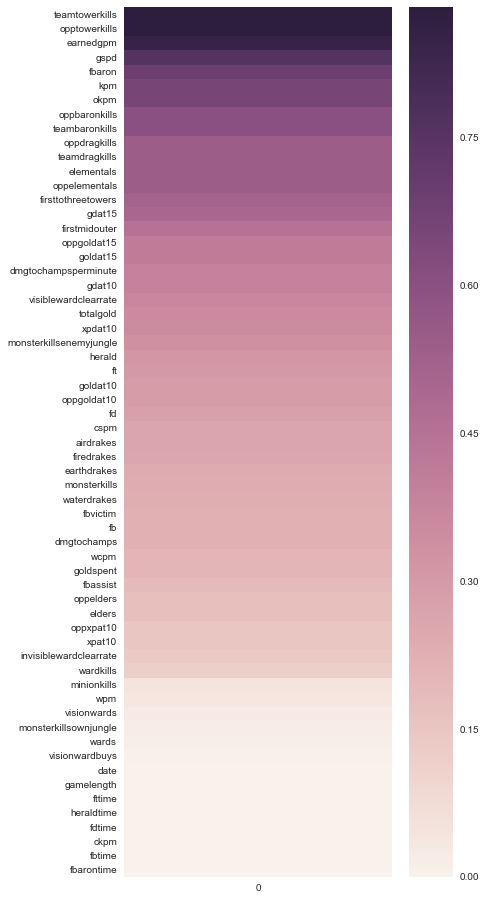

In [20]:
plt.figure(figsize=(6, 16))
sb.heatmap(pd.DataFrame(abs(corrResult)).sort_values(by = 0, ascending = False))
plt.show()

### Further processing the data
***

Next we will look at the team data grouped by unique teams.

In [21]:
teamRecords = teamDF[['result']].groupby(teamDF['team']).mean()

teamRecords.columns = ['winPct']

print(teamRecords.sort_values(by = 'winPct').head(20))

print(teamRecords.sort_values(by = 'winPct').tail(20))

                      winPct
team                        
Eanix               0.000000
Team Gates          0.000000
Besiktas            0.000000
T Show E-Sports     0.000000
Seoul City          0.000000
RisingStar Gaming   0.000000
Chungcheongnam      0.000000
Cougar eSports      0.035714
Hyper Youth Gaming  0.090909
Mousesports         0.100000
Team Mist           0.107143
Kaos Latin Gamers   0.142857
Delta Fox           0.181818
Mysterious Monkeys  0.194444
Fire Ball           0.196970
Enemy               0.200000
Nerv                0.200000
SK Gaming           0.200000
SBENU Sonicboom     0.204545
Cilekler            0.214286
                       winPct
team                         
Hard Random          0.625000
KT Rolster           0.626126
INTZ                 0.630137
J Team               0.631579
RED Canids           0.631579
Immortals            0.644068
Royal Never Give Up  0.648352
G2 Esports           0.651282
Team oNe e-Sports    0.652174
SuperMassive         0.654762
IN

I'll store team win percentages in new columns for later analysis.

In [22]:
teamDF["winRate"] = teamDF["team"].map(teamRecords['winPct'])
playerDF["teamWinRate"] = playerDF["team"].map(teamRecords['winPct'])

C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
teamFreq = teamDF['team'].value_counts()
print(teamFreq.describe())

playerFreq = playerDF['player'].value_counts()
print(playerFreq.describe())
print(playerFreq[:15])

count    161.000000
mean      66.968944
std       63.597113
min        1.000000
25%       16.000000
50%       42.000000
75%      101.000000
max      261.000000
Name: team, dtype: float64
count    994.000000
mean      54.235412
std       56.196882
min        0.000000
25%       10.000000
50%       32.000000
75%       83.000000
max      261.000000
Name: player, dtype: float64
Wolf          261
Bang          261
Faker         260
Arrow         228
Smeb          226
Crown         223
Ssumday       223
Darshan       223
Stixxay       221
Score         221
CuVee         219
Hauntzer      213
Bjergsen      213
Svenskeren    213
Xmithie       210
Name: player, dtype: int64


In [24]:
teamDF['totalGames'] = teamDF.groupby('team')['team'].transform('count')
playerDF['totalGames'] = playerDF.groupby('player')['player'].transform('count')

C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
print(playerDF['totalGames'].describe())
print(teamDF['totalGames'].describe())

count    53910.000000
mean       112.406121
std         62.605885
min          1.000000
25%         59.000000
50%        109.000000
75%        158.000000
max        261.000000
Name: totalGames, dtype: float64
count    10782.000000
mean       126.988870
std         68.038101
min          1.000000
25%         67.000000
50%        133.000000
75%        182.000000
max        261.000000
Name: totalGames, dtype: float64


We will examine if starting side appears to have an effect on result.

In [26]:
sideResult = teamDF[['result']].groupby(teamDF['side']).mean()

print(sideResult)

        result
side          
Blue  0.558523
Red   0.441477


There definitely appears to be an effect. Let's try a 2 sample t-test for significance at 95% confidence ( $ \alpha = 0.05 $).

In [27]:
blue = teamDF[teamDF['side'] == 'Blue']['result']
red = teamDF[teamDF['side'] == 'Red']['result']
print(stats.ttest_ind(blue, red))

Ttest_indResult(statistic=12.236716198327914, pvalue=3.335296975431772e-34)


With a pvalue remarkabley smaller than our $/alpha$, we can confidently say that in the great battle of red vs blue, blue wins!

With such a strong effect from starting side, we now have more questions than answers. Why does starting side act as such a strong determinant in outcome? With some domain knowledge of the game, there are a couple of theories to consider. Since blue side gets first pick of champions, they have the ability to pick up the most powerful champion to slip through bans.

The blue side team, because of the map layout, also has certain in game advantages and weaknesses in terms of dragon and baron control.

So the real question we're trying to answer is - Does blue side win more often because of an in-game advantage in map layout, or does it win more because of a pre-game advantage in the picks and bans phase.
One of the strongly correlated features with result we saw earlier was 'fb' (First Blood). This column is marked with a one for teams that draw first blood (make the first kill against their opponent), and a zero otherwise. Since first blood generally occurs before dragon and baron control have influenced the game, it might be a good place to start this examination. If the blue side is outperforming the red side in first blood, it would not be unreasonable to think that their advantage is coming from picks and bans.

In [28]:
fbBySide = teamDF[['fb']].groupby(teamDF['side']).mean()

print(fbBySide)

            fb
side          
Blue  0.522395
Red   0.477605


Indeed, blue side appears to draw first blood more often than red. Let's do a similar test for significance as before, again with $\alpha = 0.05$.

In [29]:
blue = teamDF[teamDF['side'] == 'Blue']['fb']
red = teamDF[teamDF['side'] == 'Red']['fb']

print(stats.ttest_ind(blue, red, nan_policy = 'omit'))

Ttest_indResult(statistic=4.2576111713038545, pvalue=2.0871668499470614e-05)


Again we can say there is significance to first blood being more likely to be drawn by blue side.

#### NOTE: I will finish this examination of side influence later. I plan to test for significance given the win pct of team, (using cut to mask win pct as a categorical variable of quartiles). I might also try to evaluate side effect through in-game variables, like jungle camps cleared and opp jungle camps, to see if there is a side advantage to the jungler that is influencing first blood rate.

I will add a quantile cut of winRate into teamDF.

In [30]:
# test = teamDF
# test['quality'] = test.groupby('team')['winRate'].transform(
#                 lambda x: pd.qcut(x, q=5, labels = ['Bad', 'Poor', 'Fair', 'Good', 'Great']))
# print(test[['team', 'winRate','quality']].head(30))

temp = teamDF[['team','winRate']].groupby('team').mean()
temp['quality'] = pd.qcut(temp['winRate'], q = 5, labels = ['Bad', 'Poor', 'Fair', 'Good', 'Great'])
teamDF["quality"] = teamDF["team"].map(temp['quality'])
print(teamDF[['team', 'winRate','quality']].head(10))

              team   winRate quality
10      KT Rolster  0.626126   Great
11  Longzhu Gaming  0.511111    Good
22        ESC Ever  0.418182    Fair
23   SK Telecom T1  0.693487   Great
34  Afreeca Freecs  0.495283    Fair
35      ROX Tigers  0.597087   Great
46      KT Rolster  0.626126   Great
47   SK Telecom T1  0.693487   Great
58            INTZ  0.630137   Great
59     g3nerationX  0.312500    Poor


C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


I'll now do the same thing with the 'gamelength' column.

In [31]:
teamDF['pace'] = pd.qcut(teamDF['gamelength'], q = 5, labels = ['Sprint', 'Trot', 'Walk', 'Amble', 'Crawl'])
print(teamDF[['team', 'gamelength','pace']].head(10))

              team  gamelength    pace
10      KT Rolster   42.683333   Crawl
11  Longzhu Gaming   42.683333   Crawl
22        ESC Ever   41.366667   Amble
23   SK Telecom T1   41.366667   Amble
34  Afreeca Freecs   32.900000    Trot
35      ROX Tigers   32.900000    Trot
46      KT Rolster   33.100000    Trot
47   SK Telecom T1   33.100000    Trot
58            INTZ   22.716667  Sprint
59     g3nerationX   22.716667  Sprint


C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


And the same transformation once more with the 'ckpm' (combined kills per minute) column.

In [32]:
teamDF['aggression'] = pd.qcut(teamDF['ckpm'], q = 5, labels = ['Calm', 'Alert', 'Moderate', 'Frisky', 'Wild'])
print(teamDF[['team', 'ckpm', 'aggression']].head(10))

              team      ckpm aggression
10      KT Rolster  0.210855       Calm
11  Longzhu Gaming  0.210855       Calm
22        ESC Ever  0.652699   Moderate
23   SK Telecom T1  0.652699   Moderate
34  Afreeca Freecs  1.094225       Wild
35      ROX Tigers  1.094225       Wild
46      KT Rolster  0.604230      Alert
47   SK Telecom T1  0.604230      Alert
58            INTZ  1.144534       Wild
59     g3nerationX  1.144534       Wild


C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now that I've derived these additional columns, let's explore how they relate to one another.

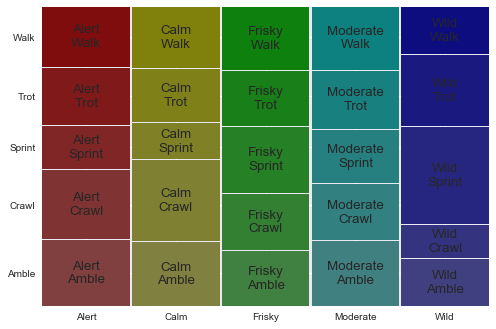

In [33]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 16.0
mosaic(teamDF, ['aggression', 'pace']);
plt.show()

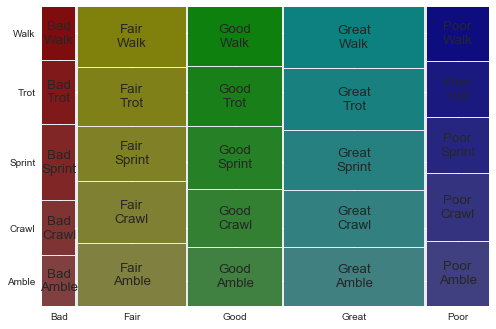

In [34]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(teamDF, ['quality', 'pace']);
plt.show()

In [35]:
teamDF['quality'].cat.reorder_categories(['Bad', 'Poor', 'Fair', 'Good', 'Great'], ordered=True, inplace = True)
teamDF['pace'].cat.reorder_categories(['Sprint', 'Trot', 'Walk', 'Amble', 'Crawl'][::-1], ordered=True, inplace = True)
teamDF['aggression'].cat.reorder_categories(['Calm', 'Alert', 'Moderate', 'Frisky', 'Wild'], ordered=True, inplace = True)
print([teamDF[c].cat.categories for c in ['quality', 'pace', 'aggression']])

[Index(['Bad', 'Poor', 'Fair', 'Good', 'Great'], dtype='object'), Index(['Crawl', 'Amble', 'Walk', 'Trot', 'Sprint'], dtype='object'), Index(['Calm', 'Alert', 'Moderate', 'Frisky', 'Wild'], dtype='object')]


## Visualizing Pace and Aggression Effects by Team Quality

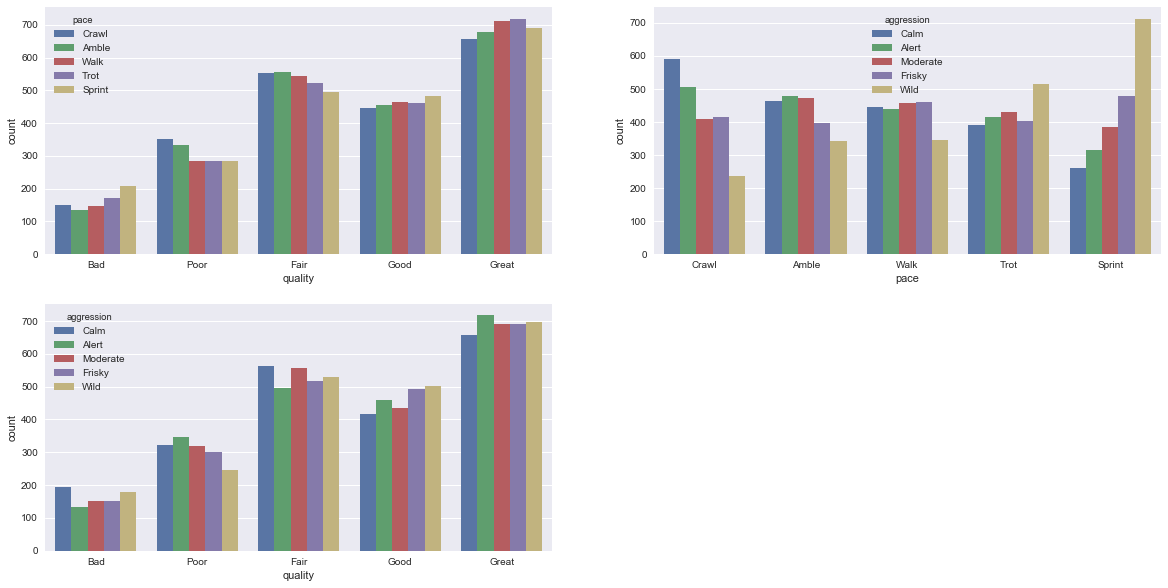

In [36]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
ax = sb.countplot(x="quality", hue="pace", data=teamDF)

plt.subplot(2,2,2)
ay = sb.countplot(hue="aggression", x="pace", data=teamDF)

plt.subplot(2,2,3)
ay = sb.countplot(hue="aggression", x="quality", data=teamDF)

plt.show()

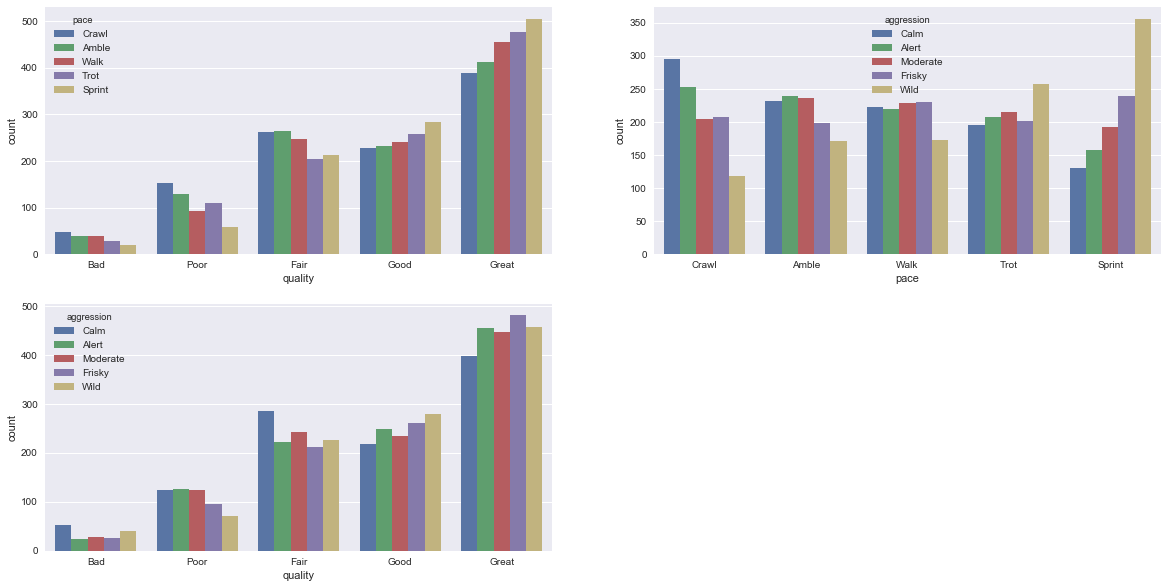

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
ax = sb.countplot(x="quality", hue="pace", data=teamDF[teamDF['result'] == 1])

plt.subplot(2,2,2)
ay = sb.countplot(hue="aggression", x="pace", data=teamDF[teamDF['result'] == 1])

plt.subplot(2,2,3)
ay = sb.countplot(hue="aggression", x="quality", data=teamDF[teamDF['result'] == 1])

plt.show()

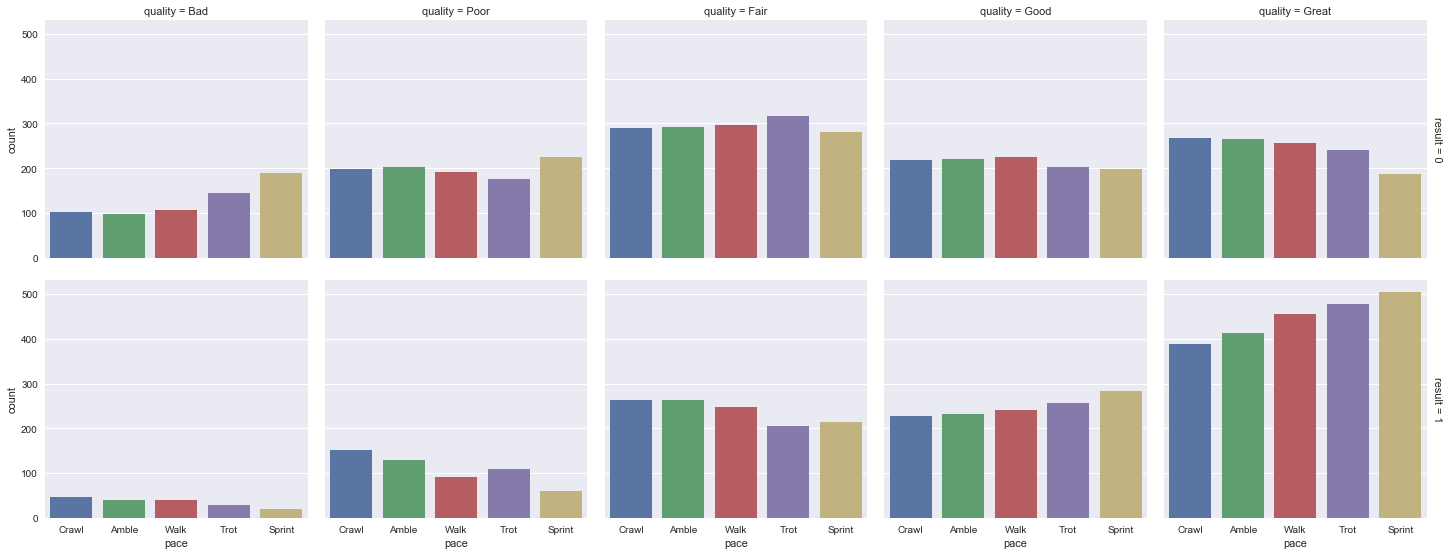

In [38]:
plt.figure(figsize=(20,10))
ay = sb.factorplot( x="pace", col = 'quality', row = 'result', data=teamDF, kind = 'count', margin_titles = True);

plt.show()

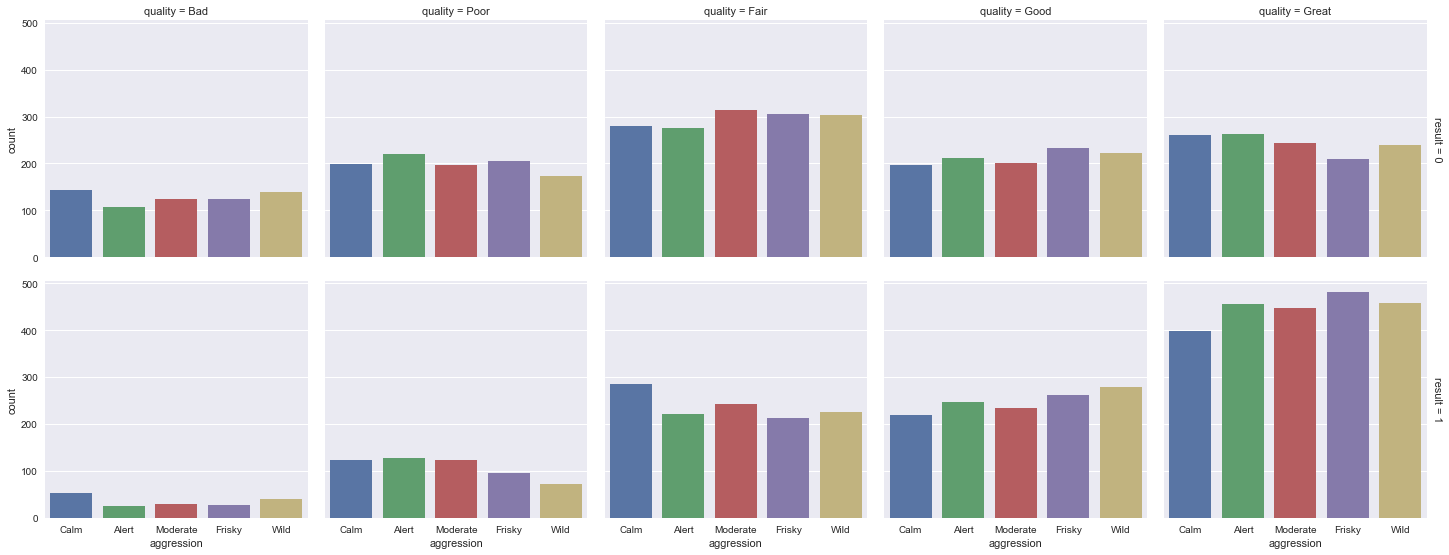

In [39]:
plt.figure(figsize=(20,10))
ay = sb.factorplot( x="aggression", col = 'quality', row = 'result', data=teamDF, kind = 'count', margin_titles = True);

plt.show()

### Visualizing pace and aggression results for games against 'Great' teams

In [40]:
great_team_games = teamDF[teamDF['quality'] == 'Great']['gameid']

great_teamDF = teamDF[teamDF['gameid'].isin(great_team_games)]

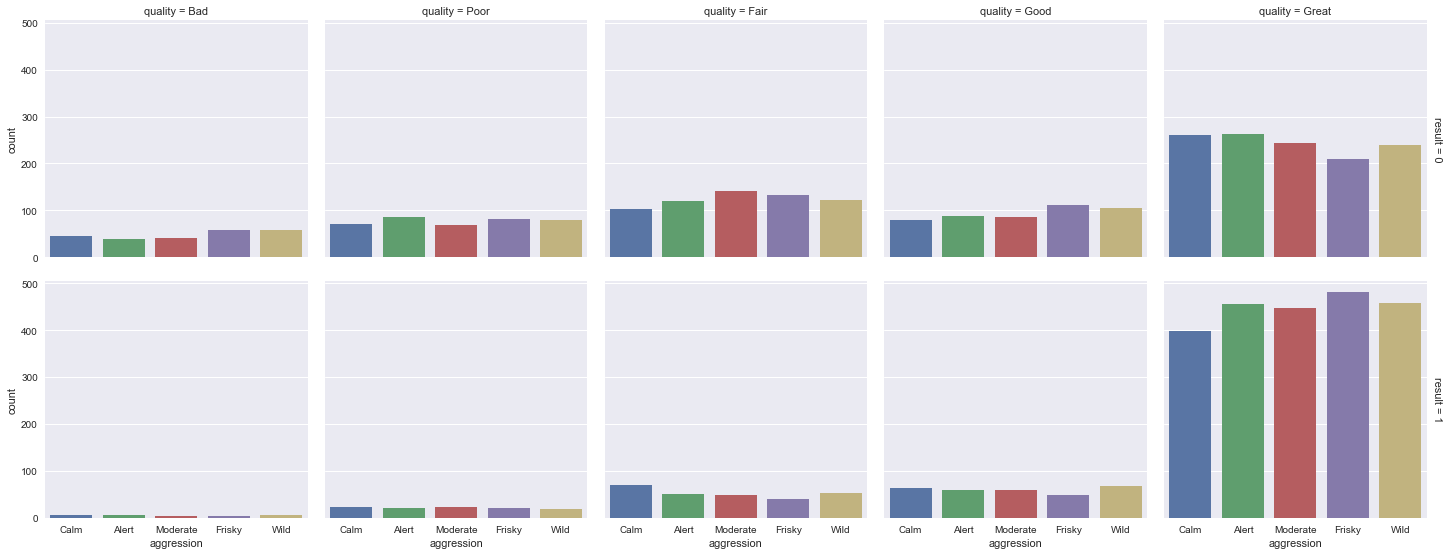

In [41]:
plt.figure(figsize=(20,10))
ay = sb.factorplot( x="aggression", col = 'quality', row = 'result', data=great_teamDF, kind = 'count', margin_titles = True);
plt.show()

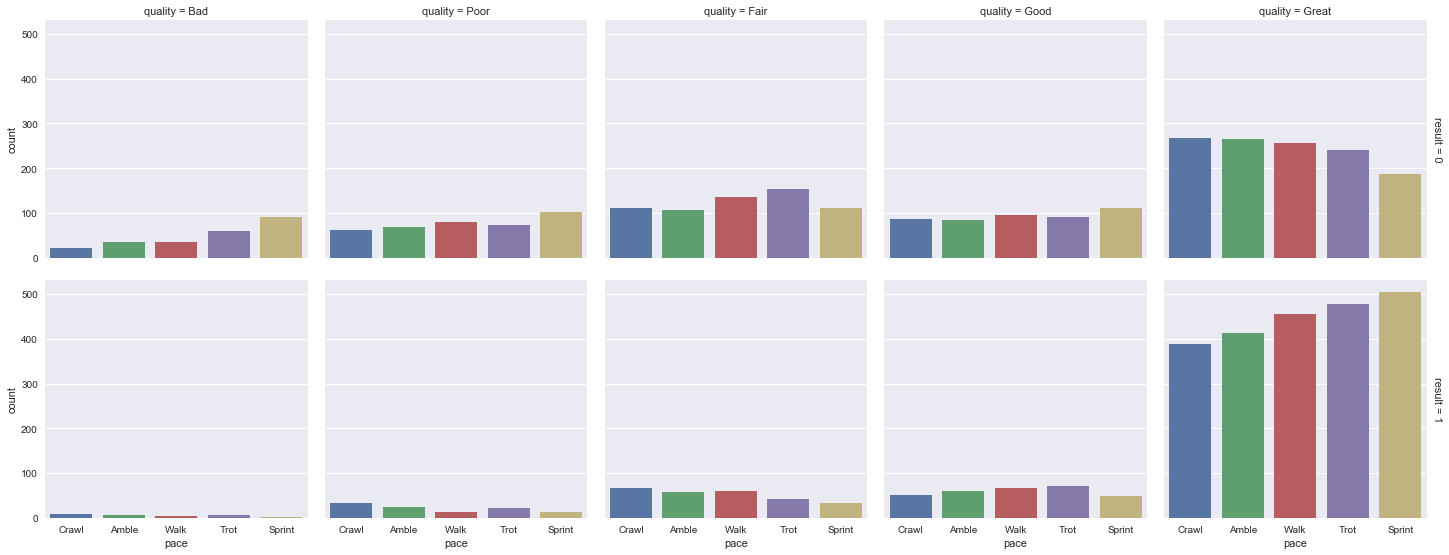

In [42]:
plt.figure(figsize=(20,10))
ay = sb.factorplot( x="pace", col = 'quality', row = 'result', data=great_teamDF, kind = 'count', margin_titles = True);
plt.show()

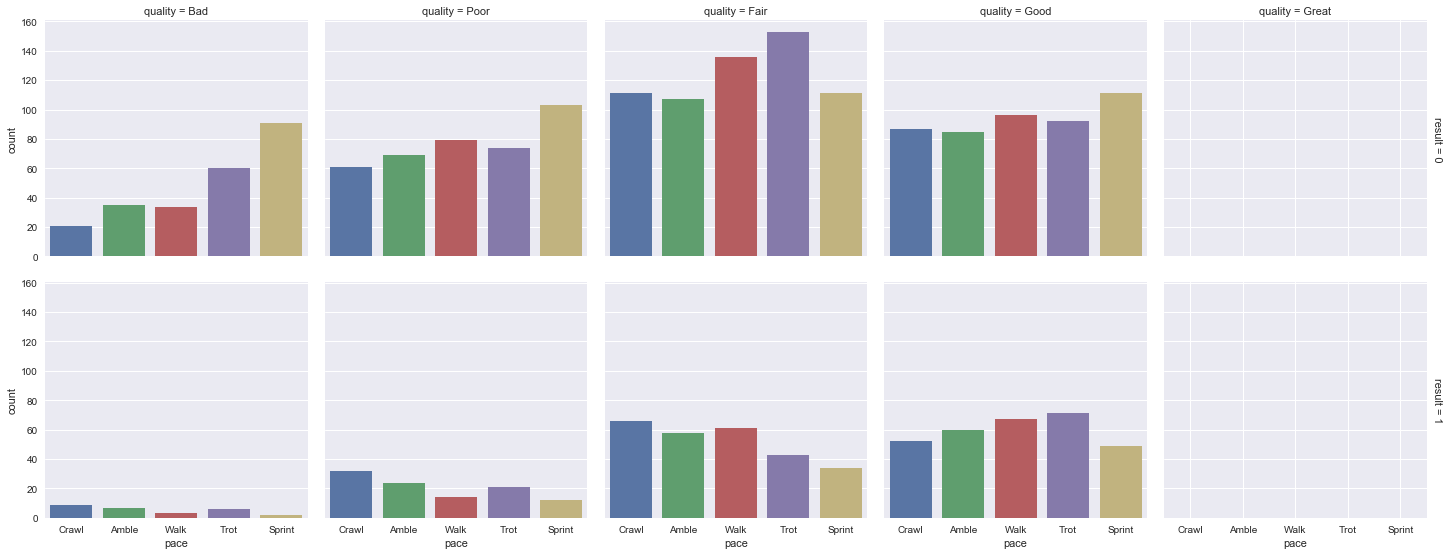

In [43]:
vs_greatDF = great_teamDF[great_teamDF['quality'] != 'Great']

plt.figure(figsize=(20,10))
ay = sb.factorplot( x="pace", col = 'quality', row = 'result', data=vs_greatDF, kind = 'count', margin_titles = True);

plt.show()

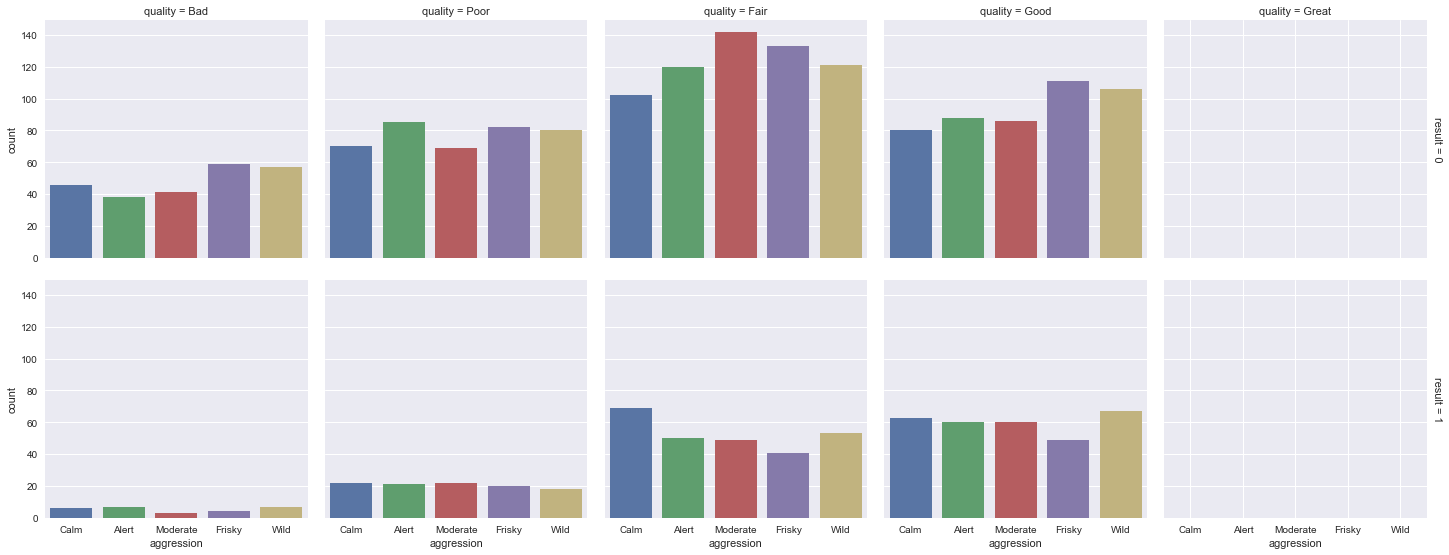

In [44]:
plt.figure(figsize=(20,10))
ay = sb.factorplot( x="aggression", col = 'quality', row = 'result', data=vs_greatDF, kind = 'count', margin_titles = True);

plt.show()

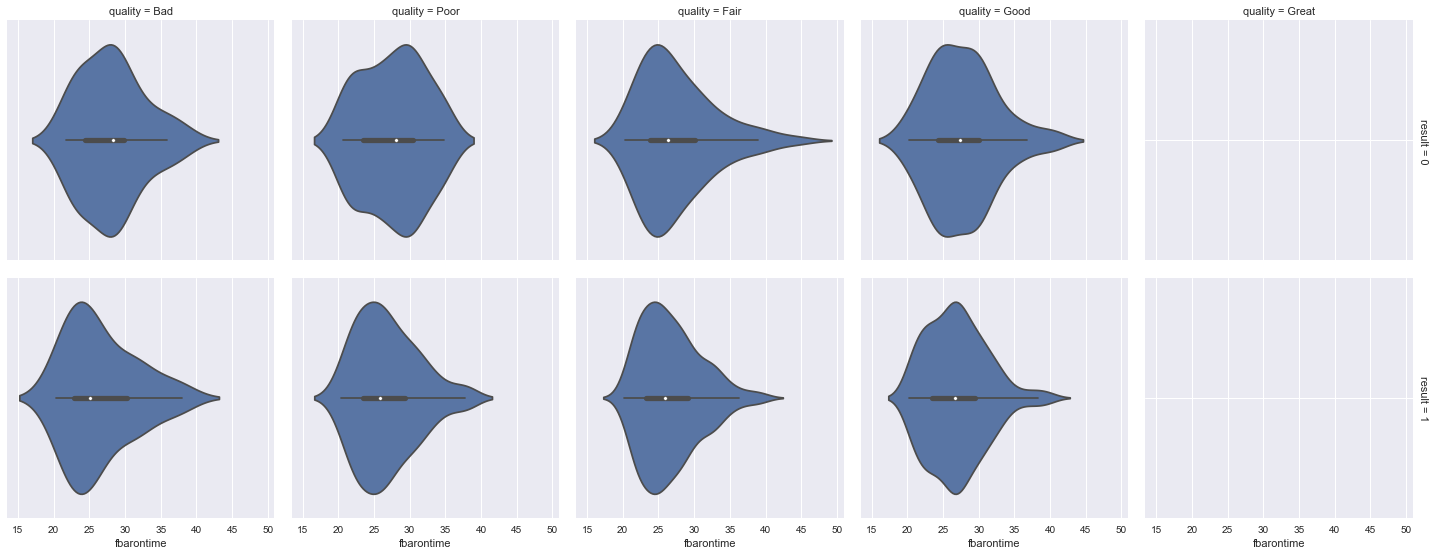

In [45]:
plt.figure(figsize=(20,10))
ay = sb.factorplot( x="fbarontime", col = 'quality', row = 'result', data=vs_greatDF[vs_greatDF.fbaron == 1], kind = 'violin', margin_titles = True);

plt.show()

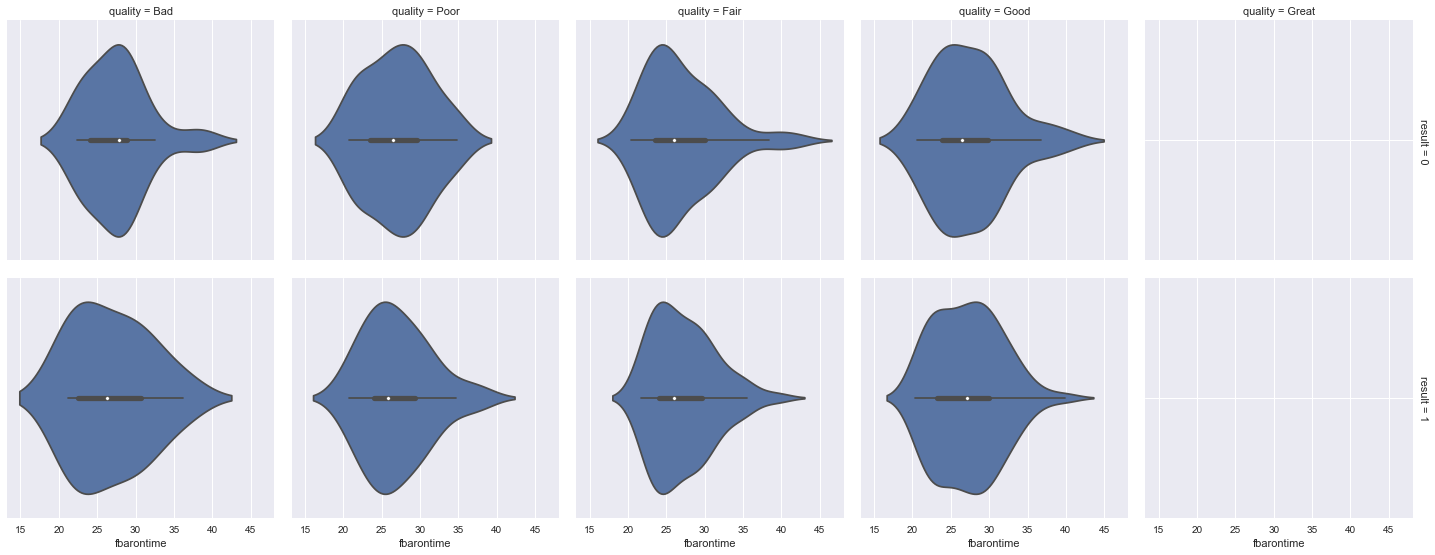

Number of games being plotted:  283


In [46]:
plt.figure(figsize=(20,10))
sneak_baron = (vs_greatDF.fbaron == 1) & (vs_greatDF.gdat15 < 0)
ay = sb.factorplot( x="fbarontime", col = 'quality', row = 'result', data=vs_greatDF[sneak_baron], kind = 'violin', margin_titles = True);

plt.show()
print('Number of games being plotted: ',vs_greatDF[sneak_baron].shape[0])

In [47]:
print('Gold Difference @ 15 mins against great teams: \n', vs_greatDF.gdat15.describe(), '\n')
print('Gold Difference @ 15 mins: \n', teamDF.gdat15.describe(), '\n')

sneak_baron = (vs_greatDF.fbaron == 1) & (vs_greatDF.gdat15 <= -1500)
print('Number of games to plot when trailing by at least 1500 at 15 minutes: ',vs_greatDF[sneak_baron].shape[0], '\n')

sneak_baron = (vs_greatDF.fbaron == 1) & (vs_greatDF.gdat15 <= -2500)
print('Number of games to plot when trailing by at least 2500 at 15 minutes: ',vs_greatDF[sneak_baron].shape[0])

Gold Difference @ 15 mins against great teams: 
 count     2030.000000
mean      -867.642365
std       2540.105373
min     -12081.000000
25%      -2411.500000
50%       -703.000000
75%        755.500000
max       8741.000000
Name: gdat15, dtype: float64 

Gold Difference @ 15 mins: 
 count     9020.000000
mean         0.000000
std       2515.584478
min     -12081.000000
25%      -1576.000000
50%          0.000000
75%       1576.000000
max      12081.000000
Name: gdat15, dtype: float64 

Number of games to plot when trailing by at least 1500 at 15 minutes:  132 

Number of games to plot when trailing by at least 2500 at 15 minutes:  59


In [48]:
sq_list = [[s,q] for s, q in zip(teamDF['side'], teamDF['quality'])]
teamDF['opp_quality'] = [sq_list[i+1][1] if sq_list[i][0] == 'Blue' else sq_list[i-1][1] for i in range(len(sq_list))]
print(teamDF[['team', 'quality', 'side','opp_quality']].head(20))

                  team quality  side opp_quality
10          KT Rolster   Great  Blue        Good
11      Longzhu Gaming    Good   Red       Great
22            ESC Ever    Fair  Blue       Great
23       SK Telecom T1   Great   Red        Fair
34      Afreeca Freecs    Fair  Blue       Great
35          ROX Tigers   Great   Red        Fair
46          KT Rolster   Great  Blue       Great
47       SK Telecom T1   Great   Red       Great
58                INTZ   Great  Blue        Poor
59         g3nerationX    Poor   Red       Great
70     Kongdoo Monster     Bad  Blue       Great
71          KT Rolster   Great   Red         Bad
82   Copenhagen Wolves    Good  Blue        Good
83                Huma    Good   Red        Good
94            CJ Entus    Poor  Blue       Great
95       SK Telecom T1   Great   Red        Poor
106      SK Telecom T1   Great  Blue        Poor
107           CJ Entus    Poor   Red       Great
118     Afreeca Freecs    Fair  Blue       Great
119         KT Rolst

C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [49]:
# ---------- First Blood by Side -----------------

    #------------ Games involving great teams --------
fb_great = great_teamDF[['fb']].groupby(great_teamDF['side']).mean()
print('------------ Games involving great teams --------')
print(fb_great)

blue = great_teamDF[great_teamDF['side'] == 'Blue']['fb']
red = great_teamDF[great_teamDF['side'] == 'Red']['fb']
print(stats.ttest_ind(blue, red, nan_policy = 'omit'))

    # ------------------- Lesser teams vs great teams -------
fb_vgreat = vs_greatDF[['fb']].groupby(vs_greatDF['side']).mean()
print('\n------------------- Lesser teams vs great teams -------')
print(fb_vgreat)

blue = vs_greatDF[vs_greatDF['side'] == 'Blue']['fb']
red = vs_greatDF[vs_greatDF['side'] == 'Red']['fb']
print(stats.ttest_ind(blue, red, nan_policy = 'omit'))

# -----------Result by Side-------------

    #------------ Games involving great teams --------
great_side = great_teamDF[['result']].groupby(great_teamDF['side']).mean()
print('\n------------ Games involving great teams --------')
print(great_side)

blue = great_teamDF[great_teamDF['side'] == 'Blue']['result']
red = great_teamDF[great_teamDF['side'] == 'Red']['result']
print(stats.ttest_ind(blue, red))

    # ------------------- Lesser teams vs great teams -------
vgreat_side = vs_greatDF[['result']].groupby(vs_greatDF['side']).mean()
print('\n------------------- Lesser teams vs great teams -------')
print(vgreat_side)

blue = vs_greatDF[vs_greatDF['side'] == 'Blue']['result']
red = vs_greatDF[vs_greatDF['side'] == 'Red']['result']
print(stats.ttest_ind(blue, red))


------------ Games involving great teams --------
            fb
side          
Blue  0.527455
Red   0.472545
Ttest_indResult(statistic=3.8839081135227, pvalue=0.00010412113194965158)

------------------- Lesser teams vs great teams -------
            fb
side          
Blue  0.499497
Red   0.437681
Ttest_indResult(statistic=2.794342811134642, pvalue=0.0052494413095834063)

------------ Games involving great teams --------
        result
side          
Blue  0.547253
Red   0.452747
Ttest_indResult(statistic=7.2670966800777945, pvalue=4.1525384047472068e-13)

------------------- Lesser teams vs great teams -------
        result
side          
Blue  0.333616
Red   0.242474
Ttest_indResult(statistic=4.9641423074258109, pvalue=7.3839952966919455e-07)


In [50]:
opp_group = teamDF[['result', 'fb']].groupby(teamDF['opp_quality']).mean()
print(opp_group)

               result        fb
opp_quality                    
Bad          0.785978  0.579292
Fair         0.553558  0.500000
Good         0.461872  0.476483
Great        0.351664  0.478041
Poor         0.646484  0.541427


In [51]:
teamDF['opp_quality'] = teamDF['opp_quality'].astype('category')
teamDF['opp_quality'].cat.reorder_categories(['Bad', 'Poor', 'Fair', 'Good', 'Great'], ordered=True, inplace = True)
qual_group = teamDF[['result', 'fb','opp_quality','quality']].groupby(['opp_quality', 'quality']).mean()
print(qual_group)

                       result        fb
opp_quality quality                    
Bad         Bad      0.500000  0.500000
            Poor     0.643478  0.574257
            Fair     0.767196  0.600000
            Good     0.838150  0.564417
            Great    0.908397  0.600000
Poor        Bad      0.356522  0.425743
            Poor     0.500000  0.500000
            Fair     0.612195  0.560127
            Good     0.661972  0.547619
            Great    0.793617  0.566845
Fair        Bad      0.232804  0.400000
            Poor     0.387805  0.439873
            Fair     0.500000  0.500000
            Good     0.605536  0.547253
            Great    0.707800  0.521307
Good        Bad      0.161850  0.435583
            Poor     0.338028  0.452381
            Fair     0.394464  0.452747
            Good     0.500000  0.500000
            Great    0.619624  0.500000
Great       Bad      0.091603  0.400000
            Poor     0.206383  0.433155
            Fair     0.292200  0.478693


C:\Users\glander\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


NOTES:
- 2 ways to perform feature selection
- see which features are most important, build model that incorporates these important features and removes/discards non-important ones
- feature engineering/feature selection 'Introduction to feature selection'
- now is a matter of seeing which observations are valid and which are noise (through si testing and simple models)
- look into stats.models has richer models around general models - api more robust

In [52]:
teamDF.to_csv(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\teamDF-Oct9.csv')

# Model Building

Now that we've explored the grouped team data, it's time to start building some logistic regressions using the 'result' column as our binary outcome variable.

### Feature Selection

In order to employ logistic regression, we first need to check for multicollinearity among the independent variables. Let's revisit the simple correlation heatmap we plotted earlier for the grouped team data.

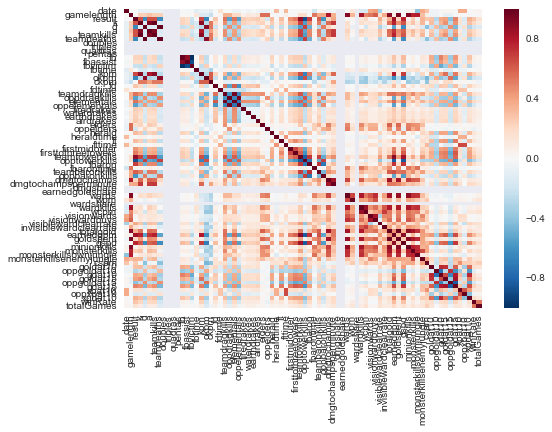

In [53]:
corr = teamDF.corr()
sb.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

There's definitely a lot of correlation happening between the independent variables. This makes sense as game duration dependent variables are going to be highly correlated - the longer the game goes, the higher the values we can expect for deaths, assists, kills, earned gold, gold spent, minions killed, etc.

Because this correlation between IV's can be more than merely pairwise, it won't suffice to merely remove the correlated IV's seen in the heatmap above. Instead, we'll build a basic regression and evaluate IV's by Variance Inflation Factor (V.I.F).

We'll start by dropping the non-numeric columns from the analysis, since VIF won't work with categorical data.

In [139]:
reg_teamDF = teamDF.copy()
reg_teamDF = reg_teamDF._get_numeric_data()

print(reg_teamDF.head())
print(reg_teamDF.columns)

            date  gamelength  result   k   d   a  teamkills  teamdeaths  \
10  42578.113113   42.683333       1   8   1  19          8           1   
11  42578.113113   42.683333       0   1   8   1          1           8   
22  42578.234757   41.366667       0   7  20  21          7          20   
23  42578.234757   41.366667       1  20   7  51         20           7   
34  42587.113715   32.900000       0  12  24  24         12          24   

    doubles  triples     ...      oppgoldat10  gdat10  goldat15  oppgoldat15  \
10      NaN      NaN     ...          15829.0   193.0   23431.0      23087.0   
11      NaN      NaN     ...          16022.0  -193.0   23087.0      23431.0   
22      NaN      NaN     ...          14963.0   537.0   23040.0      23732.0   
23      NaN      NaN     ...          15500.0  -537.0   23732.0      23040.0   
34      NaN      NaN     ...          14867.0   696.0   25023.0      23430.0   

    gdat15   xpat10  oppxpat10  xpdat10   winRate  totalGames  
10  

There's a few columns in there that are all NaN (these are all columns that have values in playerDF but not in teamDF). We won't be needing these columns either.

In [140]:
reg_teamDF.dropna(axis = 'columns', how = 'all', inplace = True)
print(reg_teamDF.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10782 entries, 10 to 64691
Data columns (total 70 columns):
date                       9714 non-null float64
gamelength                 10782 non-null float64
result                     10782 non-null int64
k                          10782 non-null int64
d                          10782 non-null int64
a                          10782 non-null int64
teamkills                  10782 non-null int64
teamdeaths                 10782 non-null int64
fb                         9020 non-null float64
fbassist                   9020 non-null float64
fbvictim                   9020 non-null float64
fbtime                     9020 non-null float64
kpm                        10774 non-null float64
okpm                       10774 non-null float64
ckpm                       10774 non-null float64
fd                         9020 non-null float64
fdtime                     9000 non-null float64
teamdragkills              10780 non-null float64
oppdragki

The remaining columns are all numerical, but the erroneous 'date' column isn't going to be much use as a predictor, so we'll go ahead and remove that too.

In [141]:
reg_teamDF = reg_teamDF.loc[:,'gamelength':]

Next, we'll use the dmatrices function from the patsy module to create a multiple regression, assigning the output to an outcome dataframe and a predcitor dataframe.

In [142]:
from patsy import dmatrices

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

cols = "+".join([x for x in list(reg_teamDF) if x != 'result'])
outcome, pred = dmatrices('result ~' + cols, reg_teamDF, return_type='dataframe')

We'll create a new dataframe, 'vif' to store the variance inflation factors and their respective labels.

In [145]:
vif = pd.DataFrame()
vif["Variance Inflation Factor"] = [variance_inflation_factor(pred.values, i) for i in range(pred.shape[1])]
vif["Regressor"] = pred.columns

vif.round(3)

,Variance Inflation Factor,Regressor
0,0.000000,Intercept
1,699.772000,gamelength
2,inf,k
3,inf,d
4,10.403000,a
5,inf,teamkills
6,inf,teamdeaths
7,inf,fb
8,4.807000,fbassist
9,inf,fbvictim


Our concerns of multicolinearity in the data have definitely been confirmed by the many IV's of the regression observed to have high VIF values. If we consider the math behind VIF's:

<center>$$ VIF_k=\frac{1}{1-R_{k}^{2}} $$</center>

Where $R_{k}^{2}$ is the $R^{2}$ obtained from performing a regression on the k<sup>th</sup> IV using all other remaining IV's. This means the more correlated an IV is with the other IV's, the higher it's VIF value will be.

However, this first stab at VIF testing has revealed another problem. Many of the regressors have VIF's of inf. That would require an $R^2$ of 1 and since it is extremely unlikely that the other IV's are perfect predictors of each other, something else is going on - NaN's. The dmatrices() function is likely unable to do a regression on an outcome variable that contains NaN-s, and is defaulting its $R^2$ to 1. We will have to either drop all columns containing NaN's, or impute missing values. We will go with imputing.

First, we'll check the outliers in the missing columns to determine whether mean or median imputation is preferrable in each. We'll call a column value an outlier if it is more than 3 standard deviations from the mean.

In [181]:
null_cols = [c for c in list(reg_teamDF) if reg_teamDF[c].isnull().values.any()]
mean = [reg_teamDF[c].mean() for c in null_cols]
sd = [reg_teamDF[c].std() for c in null_cols]
outliers = {c:{'mean':mean[i], 'sd':sd[i], 'values':[v for v in reg_teamDF[c] if abs(v - mean[i]) > 3*sd[i]]} for i, c in enumerate(null_cols)}

for k in outliers.keys():
    print('Feature: ', k, '\n')
    print('Mean: {} and St Dev: {}, Outlier Values:'.format(outliers[k]['mean'], outliers[k]['sd']))
    print(outliers[k]['values'], '\n')

Feature:  fb 

Mean: 0.5 and St Dev: 0.5000277184910267, Outlier Values:
[] 

Feature:  fbassist 

Mean: 0.4400221729490022 and St Dev: 0.4964171438006737, Outlier Values:
[] 

Feature:  fbvictim 

Mean: 0.5 and St Dev: 0.5000277184910267, Outlier Values:
[] 

Feature:  fbtime 

Mean: 6.559774005912805 and St Dev: 3.852554686429645, Outlier Values:
[21.699100000000001, 21.699100000000001, 18.740816666666667, 18.740816666666667, 19.630116666666666, 19.630116666666666, 21.060966666666666, 21.060966666666666, 18.975533333333328, 18.975533333333328, 20.391033333333333, 20.391033333333333, 20.880733333333332, 20.880733333333332, 19.078083333333328, 19.078083333333328, 32.516666666666666, 32.516666666666666, 19.762633333333333, 19.762633333333333, 19.00215, 19.00215, 27.134733333333333, 27.134733333333333, 29.21511666666667, 29.21511666666667, 20.346450000000001, 20.346450000000001, 20.927350000000001, 20.927350000000001, 18.279983333333334, 18.279983333333334, 22.170233333333329, 22.1702333

We can see that while some columns have no or very few outliers, some have quite many. Since there are roughly ten thousand observations in reg_teamDF, let's set a threshold of at least 100 outliers (~1%) as a decision point for imputing by median as opposed to mean.

In [187]:
median_cols = [o for o in outliers.keys() if len(outliers[o]['values']) >= 100]
print(median_cols)
mean_cols = list(set(null_cols) - set(median_cols))

['fbtime', 'dmgtochamps', 'wardkills', 'visionwards', 'goldspent']


Now we'll impute means into the missing values of 'mean_cols' and mediants into the missing values of 'median_cols'.

In [199]:
reg_teamDF[mean_cols] = reg_teamDF[mean_cols].fillna(reg_teamDF.mean())
reg_teamDF[median_cols] = reg_teamDF[median_cols].fillna(reg_teamDF.median())
print(reg_teamDF.isnull().values.any())

False


Now that the NaN's have been imputed, let's try our original VIF evaluation again. Since we're going to repeat the same operations over and over again, let's functionize it.

In [215]:
def get_vif(df, regressors, response):
    # Where df is a dataframe, regressors is a list of strings representing columns
    # in df, and response is a string representing the outcome column in df.
    cols = "+".join(regressors)
    outcome, pred = dmatrices(response + ' ~' + cols, df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["Variance Inflation Factor"] = [variance_inflation_factor(pred.values, i) for i in range(pred.shape[1])]
    vif["Regressor"] = pred.columns
    return vif.round(3).sort_values(by = 'Variance Inflation Factor', ascending = False )

#     cols = "+".join([x for x in list(reg_teamDF) if x != 'result'])
#     outcome, pred = dmatrices('result ~' + cols, reg_teamDF, return_type='dataframe')
#     vif = pd.DataFrame()
#     vif["Variance Inflation Factor"] = [variance_inflation_factor(pred.values, i) for i in range(pred.shape[1])]
#     vif["Regressor"] = pred.columns
#     return vif.round(3)

Okay, let's use our new get_vif() function to check VIF on the updated dataframe.

In [202]:
regressors = [x for x in list(reg_teamDF) if x != 'result']
get_vif(reg_teamDF, regressors, 'result')

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variance Inflation Factor,Regressor
0,0.000000,Intercept
1,50.467000,gamelength
2,inf,k
3,inf,d
4,9.666000,a
5,inf,teamkills
6,inf,teamdeaths
7,inf,fb
8,4.786000,fbassist
9,inf,fbvictim


Still having the same problem of infinite VIF values. In case the problem was actually being caused by integer dtypes, let's try converting them to floats.

In [225]:
reg_teamDF = reg_teamDF.astype('float64')
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


inf          21
0.000000      2
1.232000      1
2.288000      1
51.569000     1
Name: Variance Inflation Factor, dtype: int64


,Variance Inflation Factor,Regressor
65,inf,waterdrakes
48,inf,kpm
30,inf,fbvictim
29,inf,goldat15
39,inf,oppxpat10
26,inf,gdat15
25,inf,goldat10
24,inf,okpm
42,inf,oppgoldat10
43,inf,teamkills


And the same problem persists. Okay, let's proceed as if it's not an issue and continue VIF evaluation by removing (finite) high VIF value regressors, starting with 'wards'.

In [226]:
regressors = list(set(regressors) - set(['wards']))
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


inf          21
0.000000      2
1.232000      1
2.288000      1
51.569000     1
Name: Variance Inflation Factor, dtype: int64


,Variance Inflation Factor,Regressor
65,inf,waterdrakes
48,inf,kpm
30,inf,fbvictim
29,inf,goldat15
39,inf,oppxpat10
26,inf,gdat15
25,inf,goldat10
24,inf,okpm
42,inf,oppgoldat10
43,inf,teamkills


In [227]:
regressors = list(set(regressors) - set(['totalgold']))
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


inf          21
0.000000      2
1.232000      1
2.027000      1
18.982000     1
Name: Variance Inflation Factor, dtype: int64


,Variance Inflation Factor,Regressor
64,inf,waterdrakes
42,inf,oppgoldat10
25,inf,goldat10
26,inf,gdat15
29,inf,goldat15
35,inf,earthdrakes
37,inf,xpat10
39,inf,oppxpat10
43,inf,teamkills
17,inf,oppgoldat15


In [228]:
regressors = list(set(regressors) - set(['wardkills', 'dmgtochamps', 'goldspent', 'minionkills']))
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


inf          21
0.000000      2
1.231000      1
2.548000      1
10.503000     1
Name: Variance Inflation Factor, dtype: int64


,Variance Inflation Factor,Regressor
60,inf,waterdrakes
12,inf,ckpm
24,inf,gdat15
23,inf,goldat10
22,inf,okpm
32,inf,earthdrakes
34,inf,xpat10
36,inf,oppxpat10
39,inf,oppgoldat10
15,inf,oppgoldat15


Okay, this approach isn't doing anything to eliminate the infinite VIF's. It seems rather obvious now, but I realize the reason for those values is because some of the columns really __are__ perfect predictors of each other. For instance, 'elementals' is the sum of earthdrakes, airdrakes, and firedrakes. Let's test this.

In [231]:
regressors = list(set(list(reg_teamDF)) - set(['result','elementals']))
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


inf          18
0.000000      2
1.511000      2
1.535000      1
17.654000     1
Name: Variance Inflation Factor, dtype: int64


,Variance Inflation Factor,Regressor
13,inf,ckpm
40,inf,teamdeaths
25,inf,gdat15
24,inf,goldat10
23,inf,okpm
29,inf,fbvictim
60,inf,k
57,inf,xpdat10
37,inf,xpat10
16,inf,oppgoldat15


Huzzah! Finally getting somewhere with the infinite VIF's. Looking at the other probelm regressors, I realize now that 'teamdeaths' and 'd' are actually the same values, as are 'teamkills' and 'k'. 'ckpm' (combined kills per minute) is the sum of 'okpm' and 'kpm' (opponent kills per minute and kills per minute). 'fb' and 'fbvictim' are perfectly inversely related.

In [236]:
regressors = list(set(list(reg_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim']))
vif = get_vif(reg_teamDF, regressors, 'result')
print(vif['Variance Inflation Factor'].value_counts().head())
vif

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


inf         9
0.000000    2
1.511000    2
1.535000    1
2.598000    1
Name: Variance Inflation Factor, dtype: int64


,Variance Inflation Factor,Regressor
24,inf,gdat15
15,inf,oppgoldat15
46,inf,gdat10
40,inf,oppgoldat10
37,inf,oppxpat10
35,inf,xpat10
54,inf,xpdat10
27,inf,goldat15
23,inf,goldat10
32,113.678000,wards


Next we can see that the columns representing gold and opponent gold at 10 or 15 minutes ('goldat15', 'goldat10', 'xpat10', 'oppgoldat15', 'oppgoldat10', 'oppxpat10') can be perfectly predicted by themselves and the differential columns ('gdat10', 'gdat15' 'xpdat10'). Let's remove the differential columns.

In [243]:
regressors = list(set(list(reg_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim', 'gdat10', 'gdat15', 'xpdat10']))
vif = get_vif(reg_teamDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


VIF's greater than 10:  20


,Variance Inflation Factor,Regressor
31,113.678,wards
12,83.353,minionkills
44,72.829,totalgold
50,64.796,wardkills
25,55.726,dmgtochamps
8,52.341,goldspent
40,51.729,teamkills
10,50.467,gamelength
45,36.591,kpm
17,30.070,wcpm


Viola! The infinite VIF's are gone.

Now to remove the other high VIF predictors that may be creating multicollinearity. We'd like to get to a point where most VIF's are less than 5, and none are over 10. Currently there are 20 greater than 10, so there's some trimming to do.

There are a lot of predictors closely related to 'wards','minionkills', and 'totalgold', as well as many rate of time type columns that will be strongly influenced by 'gamelength'. The high VIF's of these predictors support this assessement. So let's remove all of those columns.

In [244]:
regressors = list(set(list(reg_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim', 'gdat10', 'gdat15', 'xpdat10', 'wards', 'minionkills', 'totalgold','gamelength']))
vif = get_vif(reg_teamDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


VIF's greater than 10:  12


,Variance Inflation Factor,Regressor
23,52.988,dmgtochamps
46,45.244,wardkills
37,39.029,teamkills
8,31.912,goldspent
41,27.799,kpm
11,25.890,dmgtochampsperminute
15,22.478,wcpm
34,22.386,teamdeaths
20,22.161,okpm
4,17.494,monsterkills


Okay, down to 12.

Now we can see 'dmgtochamps' and 'dmgtochampsperminute' which perfectly related by 'gamelength'. The same applies to 'teamkills' and 'kpm', as well as 'teamdeaths' and 'okpm', and 'wardkills' for 'wcpm'. We'll take out the non-rate-of-time version for each of these statistics.

We also see 'monsterkills' is derived from 'monsterkillsownjungle' and 'monsterkillsenemyjungle'.

In [248]:
regressors = list(set(list(reg_teamDF)) - set(['result','elementals', 'k', 'd', 'ckpm', 'fbvictim',
                                               'gdat10', 'gdat15', 'xpdat10', 'wards', 'minionkills',
                                               'totalgold','gamelength', 'dmgtochamps', 'teamkills', 'teamdeaths', 'wardkills', 'monsterkills']))
vif = get_vif(reg_teamDF, regressors, 'result')
print("VIF's greater than 10: ", sum(vif['Variance Inflation Factor'] > 10))
vif

C:\Users\glander\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


VIF's greater than 10:  2


,Variance Inflation Factor,Regressor
49,16.659,earnedgpm
27,12.363,goldspent
44,8.322,gspd
30,8.156,kpm
36,8.056,teamtowerkills
48,7.164,opptowerkills
46,6.524,teamdragkills
10,6.300,oppdragkills
25,5.804,a
12,5.375,teambaronkills


***
# In Progress Miscellaneous

### Macro strategies to impact game outcome

I would like to investigate if there are playstyle strategies available to teams that will improve their likelihood of winning. In american football for instance, bad teams - meaning those with lower records - are statistically more likely to beat a good opponent by raising the variance of the game through things like trick plays, unexpected onside kicks, aggressive throw selection, 4th down calls, etc. I'm interested in seeing if there are extensions of this in competitive League of Legends.

For instance, are the best teams (top quartile of win pct) more or less likely to win longer games? The same question with 'bloodier' (high values for 'ckpm' - combined kills per minute) games.

First, let's get an idea of the distributions of gamelength and ckpm.

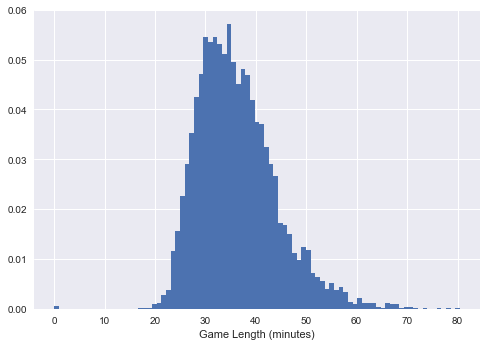

In [56]:
plt.hist(teamDF['gamelength'], bins = 'fd', normed = True)
plt.xlabel("Game Length (minutes)")
plt.show()

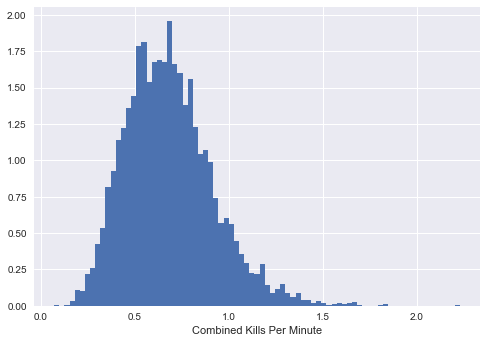

In [57]:
plt.hist(teamDF['ckpm'].dropna(), bins = 'fd', normed = True)
plt.xlabel("Combined Kills Per Minute")
plt.show()

In [58]:
#df.to_excel(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\Merged-LoL-Data-Sep19.xlsx')

In [59]:
#df.to_csv(r'C:\Users\glander\Documents\DataScience\Springboard\Capstone1\Merged-LoL-Data-Sep25.csv')